In [1]:
import sys
sys.path.append('../')
from utilities import *
import utilities

In [2]:
mean, std = get_mean_and_std(224)
print(f'Mean: {mean}')
print(f'Std Dev: {std}')

Mean: tensor([0.3282, 0.3282, 0.3281])
Std Dev: tensor([0.2190, 0.2190, 0.2190])


In [3]:
patch_size = 16         # Patch size (P) = 16
latent_size = 768       # Latent vector (D). ViT-Base uses 768
n_channels = 3          # Number of channels for input images
num_heads = 12          # ViT-Base uses 12 heads
num_encoders = 12       # ViT-Base uses 12 encoder layers
dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
num_classes = 3        # Number of classes in Busi dataset
size = 224              # Size used for training = 224

epochs = 2             # Number of epochs
base_lr = 1e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)
batch_size = 32

In [5]:
# Define transformations for the training data
transform_training_data = Compose([
    RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Randomly crop and resize to 224x224
    RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.RandomRotation(10),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    ToTensor(),  # Convert PIL image to Tensor
    Normalize(mean, std)  # Normalize with mean and std for grayscale images
])

# Define the transformations for validation data (no augmentation, only necessary processing)
transform_validation_data = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean, std)
])

train_loader, val_loader = get_train_and_validation_loader(transform_training_data, transform_validation_data, batch_size=batch_size)

In [6]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, device=device, latent_size=latent_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.input_size = self.patch_size * self.patch_size * self.n_channels

        self.linearProjection = nn.Linear(self.input_size, self.latent_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, self.latent_size))
        self.pos_embedding = nn.Parameter(torch.randn(1, (size // patch_size) ** 2 + 1, self.latent_size))

    def forward(self, input_data):
        batch_size = input_data.size(0)
        input_data = input_data.to(self.device)

        patches = einops.rearrange(input_data, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patch_size, w1=self.patch_size)
        linear_projection = self.linearProjection(patches).to(self.device)
        class_token = self.class_token.expand(batch_size, -1, -1)
        pos_embedding = self.pos_embedding.expand(batch_size, -1, -1)

        linear_projection = torch.cat((class_token, linear_projection), dim=1)
        linear_projection += pos_embedding

        return linear_projection

In [7]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size=latent_size, num_heads=num_heads, device=device, dropout=dropout):
        super(EncoderBlock, self).__init__()
        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        self.norm = nn.LayerNorm(self.latent_size)
        self.multihead = nn.MultiheadAttention(self.latent_size, self.num_heads, dropout=self.dropout)
        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):
        firstNorm_out = self.norm(embedded_patches)
        attention_output = self.multihead(firstNorm_out, firstNorm_out, firstNorm_out)[0]
        first_added_output = attention_output + embedded_patches

        secondNorm_out = self.norm(first_added_output)
        ff_output = self.enc_MLP(secondNorm_out)

        return ff_output + first_added_output

In [8]:
class VitTransformer(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(VitTransformer, self).__init__()
        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()
        self.encStack = nn.ModuleList([EncoderBlock() for _ in range(self.num_encoders)])
        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):
        enc_output = self.embedding(test_input)
        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output)
        cls_token_embedding = enc_output[:, 0]
        return self.MLP_head(cls_token_embedding)

In [9]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1/2
Training: Loss: 1.8455 | Acc: 44.71% | F1: 0.43 | Precision: 0.42 | Recall: 0.45
Validation: Loss: 1.3933 | Acc: 24.36% | F1: 0.10 | Precision: 0.82 | Recall: 0.24


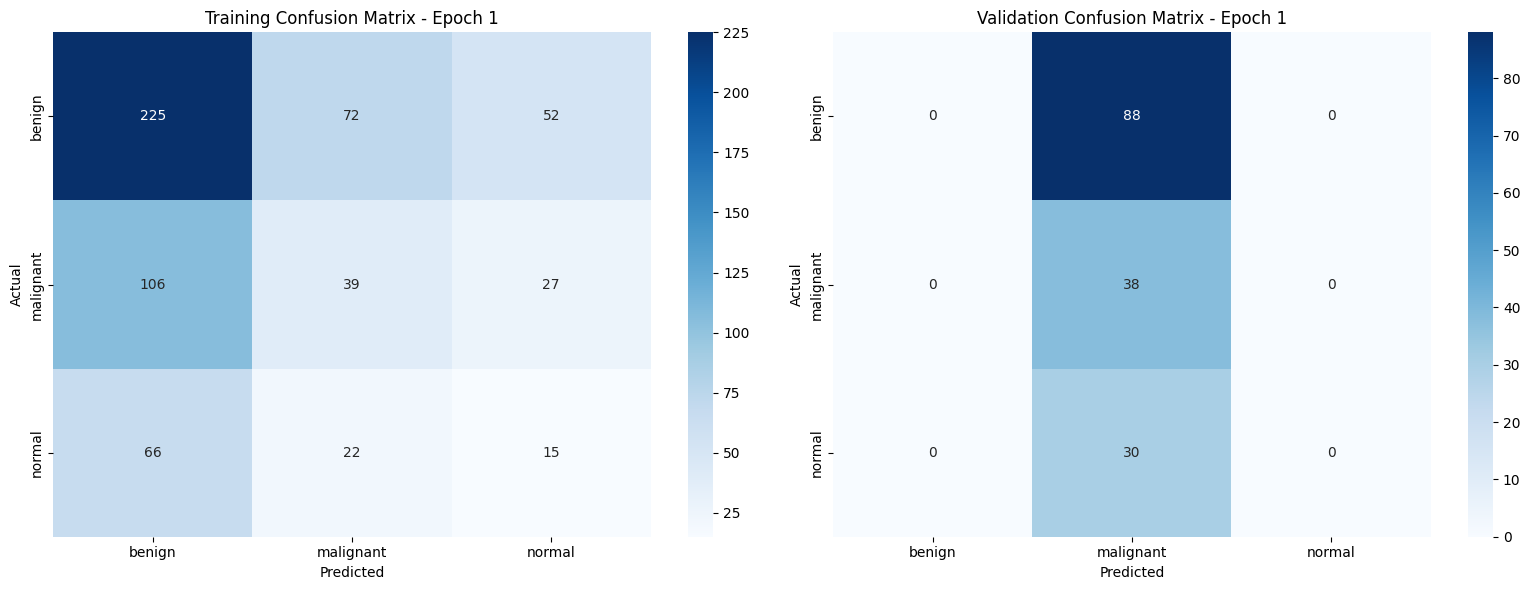


------------------------------------------------------------------------------------------------------------------



Training Batch:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Batch:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 2/2
Training: Loss: 1.1153 | Acc: 47.60% | F1: 0.44 | Precision: 0.43 | Recall: 0.48
Validation: Loss: 1.0775 | Acc: 56.41% | F1: 0.41 | Precision: 0.75 | Recall: 0.56


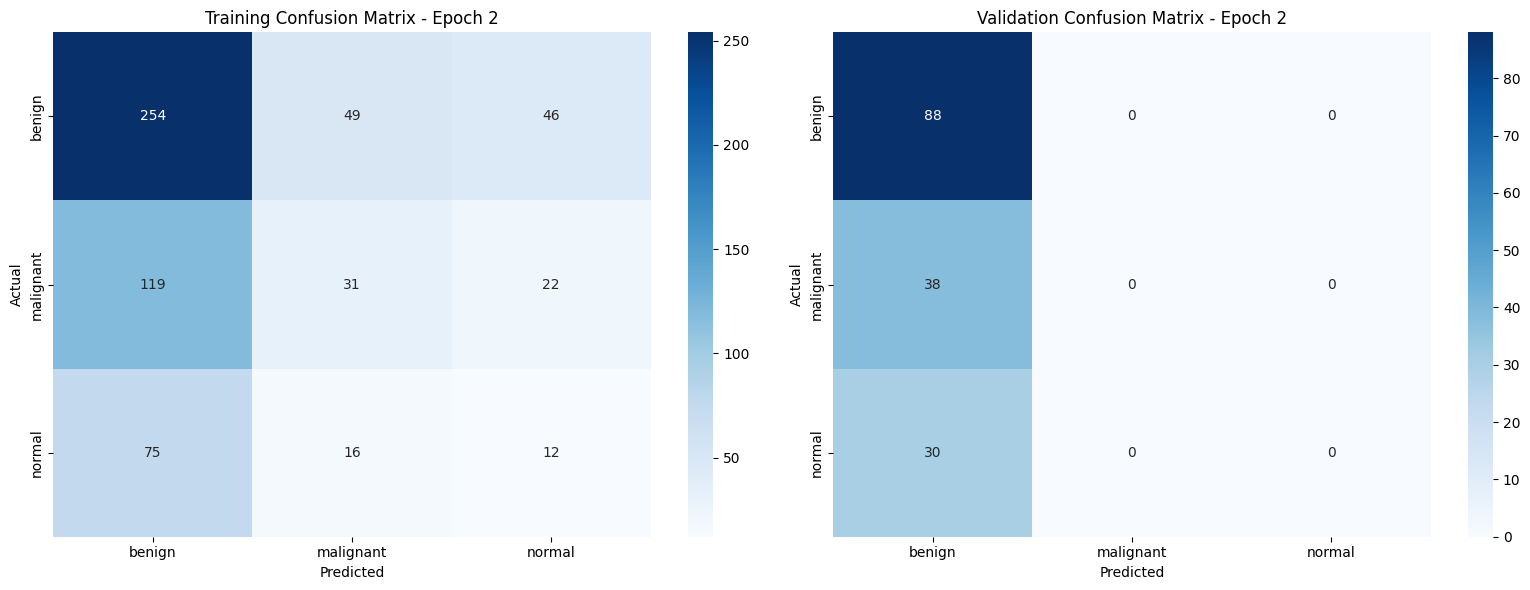


------------------------------------------------------------------------------------------------------------------



In [10]:
train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores, train_recalls, val_recalls, train_precisions, val_precisions, train_conf_matrices, val_conf_matrices, all_train_labels, all_train_probs, all_val_labels, all_val_probs = vit_train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device)

In [10]:
save_model(model, './models/vit-impl-2.pth')

Model saved to /content/drive/MyDrive/LU_ML MS thesis/Project/vit/models/vit-2.pth.
Model loaded from /content/drive/MyDrive/LU_ML MS thesis/Project/vit/models/vit-2.pth.


In [ ]:
model = VitTransformer(num_encoders, latent_size, device, num_classes).to(device)
load_model(model, './models/vit-impl-2.pth')

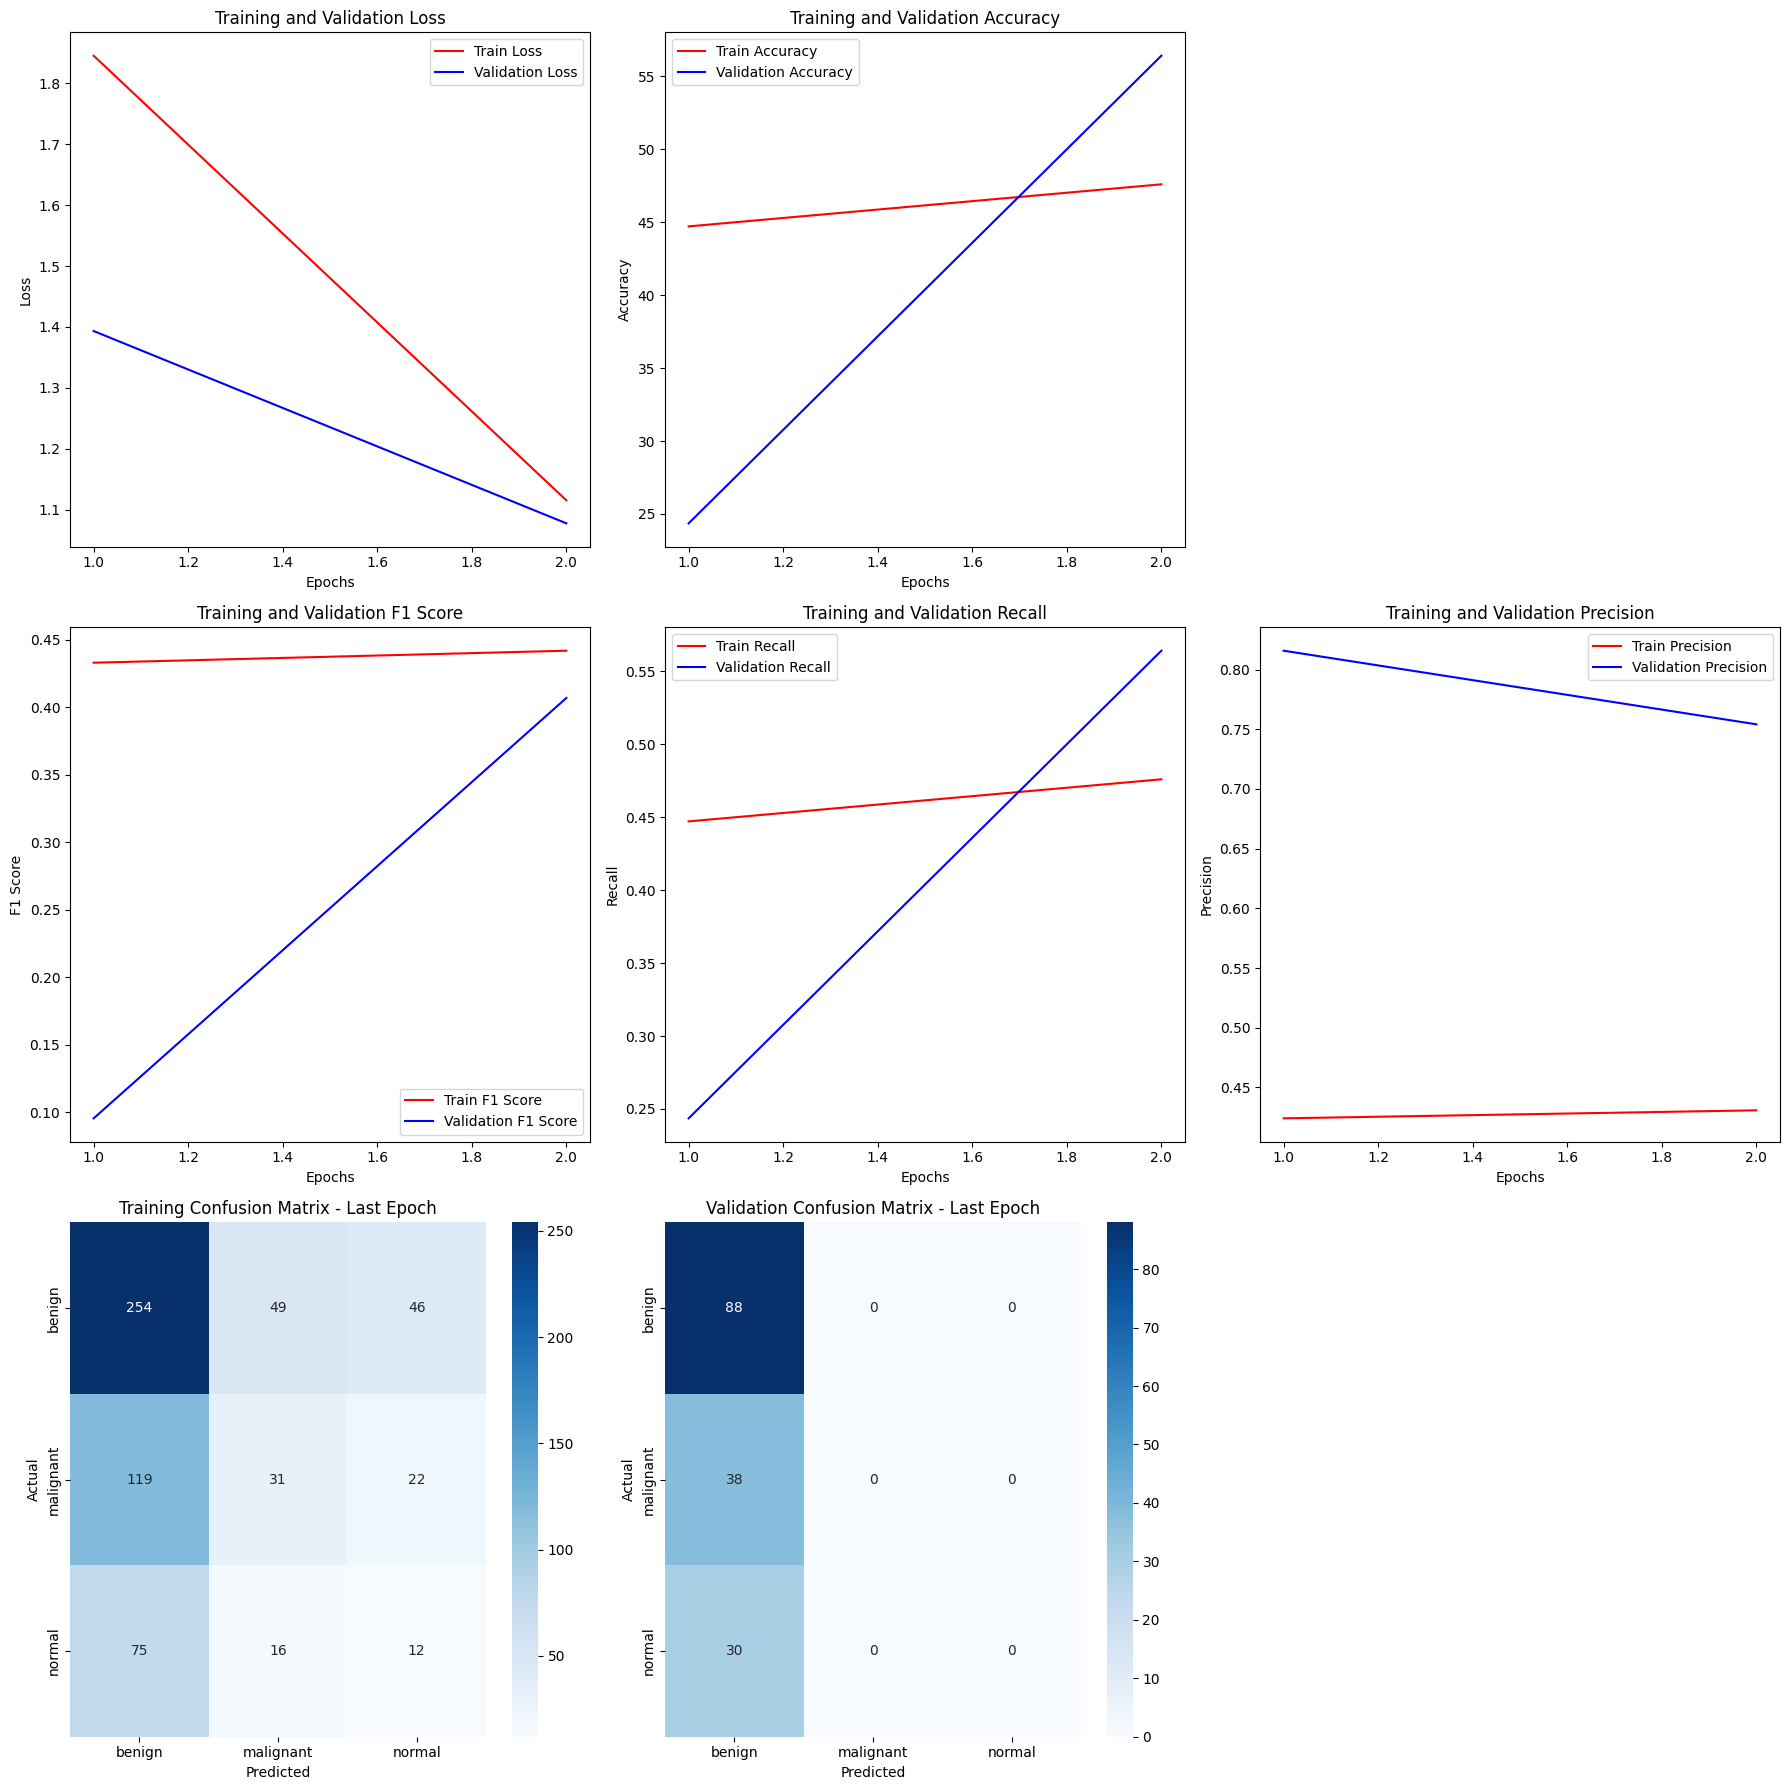

In [11]:
vit_plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores, train_recalls, val_recalls, train_precisions, val_precisions, train_conf_matrices, val_conf_matrices, all_train_labels, all_train_probs, all_val_labels, all_val_probs, train_loader.dataset.dataset.classes)

Actual labels:  benign malignant benign malignant
Predicted labels:  benign benign benign benign


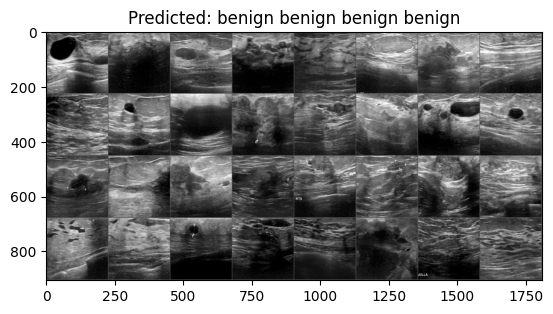

In [13]:
vit_test(model, val_loader, train_loader.dataset.dataset.classes, mean, std)